In [4]:
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from GroupingAlgorithms import *
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.transformers import FreezeCoreTransformer
# from qiskit_nature.drivers import PyQuanteDriver
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.opflow.primitive_ops import Z2Symmetries
from qiskit.opflow import converters
from qiskit.algorithms.optimizers import SPSA
from IPython.display import display, clear_output

## Experiment
This notebook is a copy of the one used to run the experiment of VQE with HEEM for the LiH molecule in an IBM quantum device. First, we load our account, define the backend and the number of shots.

In [5]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
# backend_exp   = provider.get_backend('ibmq_paris')
backend_exp   = provider.get_backend('ibmq_guadalupe')
WC_exp        = get_backend_conectivity(backend_exp)
NUM_SHOTS = 2**13  # Number of shots for each circuit

Defining the quantum instance to run the experiment.

In [6]:
quantum_instance = QuantumInstance( backend_exp, shots = NUM_SHOTS )

Creating the Hamiltonian of the LiH molecule.

In [7]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(molecule)
qmolecule = driver.run()
freezeCoreTransfomer = FreezeCoreTransformer( freeze_core=True, remove_orbitals= [3,4] )
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'
mapper = ParityMapper()

converter = QubitConverter( mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1],) #1] 

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha, problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

qubit_op = converter.convert(main_op, num_particles=num_particles)

num_qubits = qubit_op.num_qubits
WC = list(range(num_qubits))
WC = list(permutations(list(range(num_qubits)),2))

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

print( num_qubits )
print( qubit_op )

4
-0.2031660615055879 * IIII
- 0.3652586902160348 * ZIII
+ 0.0927599493349712 * IZII
- 0.2118898429700965 * ZZII
+ (0.36525869021603485+2.7755575615628914e-17j) * IIZI
- 0.11384335176465854 * ZIZI
+ 0.1139525188304805 * IZZI
+ (-0.06044012857314275-3.469446951953614e-18j) * ZZZI
- 0.09275994933497117 * IIIZ
+ 0.11395251883048049 * ZIIZ
+ (-0.12274244052546182-6.938893903907228e-18j) * IZIZ
+ 0.05628878167215863 * ZZIZ
+ (-0.2118898429700965+1.3877787807814457e-17j) * IIZZ
+ 0.06044012857314275 * ZIZZ
+ (-0.05628878167215863-3.469446951953614e-18j) * IZZZ
+ 0.08460131391824587 * ZZZZ
+ 0.01938940858371085 * XIII
+ (-0.019389408583710854+4.336808689942018e-19j) * XZII
- 0.01095277357378463 * XIZI
+ 0.01095277357378463 * XZZI
+ 0.012779333033002545 * XIIZ
- 0.012779333033002545 * XZIZ
- 0.0090025012438386 * XIZZ
+ 0.0090025012438386 * XZZZ
+ 0.0029411410872570622 * IXII
+ 0.0029411410872570622 * ZXII
+ (-0.010681856282912659-8.673617379884035e-19j) * IXZI
- 0.010681856282912659 * ZXZI
+ 0

Creating the variational form. This is also hardware efficient.

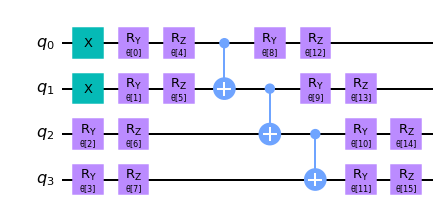

In [9]:
entangled_layer = []
for qbs in WC_exp :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

Defining the callback, the optimizer and the initial parameters. 

In [10]:
# Warning: This callback is deprecated in our code.
def callback( evals, params ):  
    display("{}, {}".format(len(evaluations),evals))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []

In [11]:
optimizer = SPSA( maxiter=150, last_avg=1 )

In [12]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var

Runing the experiment.

In [13]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', conectivity = WC_exp, callback=callback, quantum_instance=quantum_instance )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-7.769308288344124


Saving the data.

In [14]:
np.save( 'exp_params_rep_1_'+backend_exp.name(), np.array(parameters) )
np.save( 'exp_energy_rep_1_'+backend_exp.name(), np.array(evaluations) )

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table